In [1]:
import asteroid
asteroid.__version__

'0.3.3'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
from pathlib import Path
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
p = Path(r'Notebooks/MiniLibriMix').glob('**/*')
FILES = [x for x in p if x.is_file()]

In [4]:
class DataHelper(object):
    def __init__(self, files=FILES):
        self.files = files
        
    def __len__(self):
        return len(self.files)
        
    def get_file_types(self):
        strings = [str(f) for f in self.files]
        types = set(re.split('\.',s)[-1] for s in strings)
        return types
    
    def train_test_split(self):
        strings = [str(f) for f in self.files]
        train = [s for s in strings if re.search('/train/', s)]
        test = [s for s in strings if re.search('/val/', s)]
        return train, test
    
    def load_csv_tables(self):
        train, test = self.train_test_split()
        
        train_csvs = [t for t in train if re.search('.csv', t)]
        test_csvs = [t for t in test if re.search('.csv', t)]
        
        train_dfs = [pd.read_csv(t).rename(columns={'Unnamed: 0': 'index'}) for t in train_csvs]
        train_names = [re.split('/', re.split('\.', t)[-2])[-1] for t in train_csvs]
        
        test_dfs = [pd.read_csv(t).rename(columns={'Unnamed: 0': 'index'}) for t in test_csvs]
        test_names = [re.split('/', re.split('\.', t)[-2])[-1] for t in train_csvs]
        
        train_dict = dict(zip(train_names, train_dfs))
        test_dict = dict(zip(test_names, test_dfs))
        return train_dict, test_dict

In [5]:
datahelper = DataHelper()
len(datahelper)
datahelper.get_file_types()
train, test = datahelper.train_test_split()
len(train), len(test)
train_dfs, test_dfs = datahelper.load_csv_tables()

In [6]:
train_df = train_dfs['mixture_train_mix_clean']

In [7]:
train_df.head()

,index,mixture_ID,mixture_path,source_1_path,source_2_path,length
0,70,5400-34479-0005_4973-24515-0007,MiniLibriMix/train/mix_clean/5400-34479-0005_4...,MiniLibriMix/train/s1/5400-34479-0005_4973-245...,MiniLibriMix/train/s2/5400-34479-0005_4973-245...,121920.0
1,178,3876-174960-0020_7555-101283-0054,MiniLibriMix/train/mix_clean/3876-174960-0020_...,MiniLibriMix/train/s1/3876-174960-0020_7555-10...,MiniLibriMix/train/s2/3876-174960-0020_7555-10...,53360.0
2,207,3025-12971-0034_781-127518-0038,MiniLibriMix/train/mix_clean/3025-12971-0034_7...,MiniLibriMix/train/s1/3025-12971-0034_781-1275...,MiniLibriMix/train/s2/3025-12971-0034_781-1275...,108560.0
3,220,7285-72200-0020_4246-12545-0013,MiniLibriMix/train/mix_clean/7285-72200-0020_4...,MiniLibriMix/train/s1/7285-72200-0020_4246-125...,MiniLibriMix/train/s2/7285-72200-0020_4246-125...,103720.0
4,236,4363-14936-0060_6993-83607-0024,MiniLibriMix/train/mix_clean/4363-14936-0060_6...,MiniLibriMix/train/s1/4363-14936-0060_6993-836...,MiniLibriMix/train/s2/4363-14936-0060_6993-836...,101440.0


In [8]:
example_1 = train_df.iloc[0]
example_1

index                                                           70
mixture_ID                         5400-34479-0005_4973-24515-0007
mixture_path     MiniLibriMix/train/mix_clean/5400-34479-0005_4...
source_1_path    MiniLibriMix/train/s1/5400-34479-0005_4973-245...
source_2_path    MiniLibriMix/train/s2/5400-34479-0005_4973-245...
length                                                      121920
Name: 0, dtype: object

In [9]:
mixture_path = example_1['mixture_path']
src_1_path = example_1['source_1_path']
src_2_path = example_1['source_2_path']

In [10]:
mixture, sr = librosa.load('Notebooks/'+mixture_path, sr=None)
src_1, _ = librosa.load('Notebooks/'+src_1_path, sr=None)
src_2, _ = librosa.load('Notebooks/'+src_2_path, sr=None)

In [11]:
from IPython.display import Audio
Audio(mixture, rate=8000)

In [12]:
Audio(src_1, rate=8000)

In [13]:
Audio(src_2, rate=8000)

In [14]:
def generate_spectrogram(signal, sr=8000, low_lim=0, high_lim=8000//2):
    S = librosa.stft(signal)
    return S

def plot_spectrogram(S, title, sr=8000, low_lim=0, high_lim=8000//2):
    import librosa.display
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(D, y_axis='linear', fmax=sr//2, x_axis='time')
    plt.title(title)
    plt.ylim([low_lim, high_lim])
    plt.colorbar()

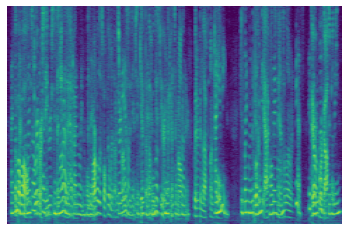

In [15]:
S = generate_spectrogram(mixture)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.imshow(D, aspect='auto')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

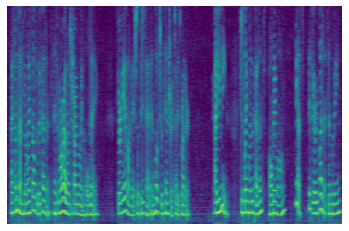

In [16]:
S = generate_spectrogram(src_1)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.imshow(D, aspect='auto')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

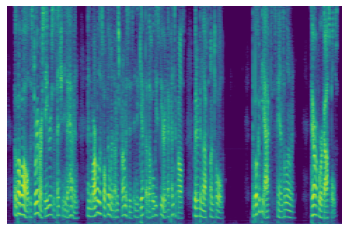

In [17]:
S = generate_spectrogram(src_2)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.imshow(D, aspect='auto')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

# UNET

In [20]:
import tensorflow as tf

In [50]:
LATENT_DIM=256
DIMS=(1024,128,1)
class UNET(tf.keras.Model):

    def __init__(self, latent_dim=LATENT_DIM, dims=DIMS):
        super(UNET, self).__init__()
        self.latent_dim = latent_dim
        self.dims = dims


        self.unet = self.construct_unet()

    def unet_convblock_down(self, inputs, channels=16):
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(inputs)
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        pool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
        return x, pool

    def unet_convblock_up(self, last_conv, cross_conv, channels=16):
        up_conv = tf.keras.layers.UpSampling2D(size=(2, 2))(last_conv)
        merge = tf.keras.layers.concatenate([up_conv, cross_conv], axis=3)
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(merge)
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        return x

    def construct_unet(self):
        inputs = tf.keras.Input(shape=self.dims)
        up_1, pool_1 = self.unet_convblock_down(inputs, channels=16)
        up_2, pool_2 = self.unet_convblock_down(pool_1, channels=32)
        up_3, pool_3 = self.unet_convblock_down(pool_2, channels=64)
        up_4, pool_4 = self.unet_convblock_down(pool_3, channels=128)
        conv_middle = tf.keras.layers.Conv2D(filters=128,
                                             kernel_size=(3, 3), 
                                             activation=tf.nn.leaky_relu, 
                                             kernel_initializer='he_normal',
                                             padding='same')(pool_4)
        conv_middle = tf.keras.layers.Conv2D(filters=128,
                                             kernel_size=(3, 3), 
                                             activation=tf.nn.leaky_relu, 
                                             kernel_initializer='he_normal',
                                             padding='same')(conv_middle)
        down_4 = self.unet_convblock_up(conv_middle, up_4, channels=128)
        down_3 = self.unet_convblock_up(down_4, up_3, channels=64)
        down_2 = self.unet_convblock_up(down_3, up_2, channels=32)
        down_1 = self.unet_convblock_up(down_2, up_1, channels=16)
        outputs = tf.keras.layers.Conv2D(2, (1, 1), activation='tanh')(down_1)
        unet = tf.keras.Model(inputs=inputs, outputs=outputs)
        return unet

    def call(self, x):
        return self.unet(x)

unet_example = UNET()
unet_example.unet.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1024, 128, 1 0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 1024, 128, 16 160         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 1024, 128, 16 2320        conv2d_156[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 512, 64, 16)  0           conv2d_157[0][0]                 
____________________________________________________________________________________________

In [37]:
D_fit = D[0:1024, 0:128]

In [38]:
D_fit

array([[-61.12857 , -61.85273 , -60.847397, ..., -52.534294, -59.994186,
        -60.849457],
       [-68.956665, -67.030266, -67.04606 , ..., -58.12271 , -66.4104  ,
        -67.995895],
       [-62.555794, -62.010395, -62.955425, ..., -63.35615 , -75.54884 ,
        -75.67404 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -47.772697, -52.09459 ,
        -68.5945  ],
       [-80.      , -80.      , -80.      , ..., -46.68756 , -53.67465 ,
        -78.38519 ],
       [-80.      , -80.      , -80.      , ..., -47.4649  , -54.83457 ,
        -70.53505 ]], dtype=float32)

In [51]:
S_train = np.expand_dims(generate_spectrogram(mixture)[:1024, :128], axis=0)
S_train.shape

(1, 1024, 128)

In [52]:
S_test1 = np.expand_dims(generate_spectrogram(src_1)[:1024, :128], axis=-1)

In [53]:
S_test2 = np.expand_dims(generate_spectrogram(src_2)[:1024, :128], axis=-1)

In [54]:
S_test = np.expand_dims(np.concatenate([S_test1, S_test2], axis=-1), axis=0)
S_test.shape

(1, 1024, 128, 2)

In [60]:
model = UNET().unet
model.compile(loss='mean_squared_error',
                       optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1024, 128, 1 0                                            
__________________________________________________________________________________________________
conv2d_251 (Conv2D)             (None, 1024, 128, 16 160         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_252 (Conv2D)             (None, 1024, 128, 16 2320        conv2d_251[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_60 (MaxPooling2D) (None, 512, 64, 16)  0           conv2d_252[0][0]                 
___________________________________________________________________________________________

In [80]:
model.fit(S_train, S_test,
         epochs=50,
         verbose=1)

Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1658
Epoch 2/50
1/1 [==============================] - 0s 933us/step - loss: 0.1656
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1654
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1653
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1651
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1650
Epoch 7/50
1/1 [==============================] - 0s 934us/step - loss: 0.1648
Epoch 8/50
1/1 [==============================] - 0s 854us/step - loss: 0.1647
Epoch 9/50
1/1 [==============================] - 0s 902us/step - loss: 0.1646
Epoch 10/50
1/1 [==============================] - 0s 876us/step - loss: 0.1644
Epoch 11/50
1/1 [==============================] - 0s 955us/step - loss: 0.1643
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1642
Epoch 13/50
1/1 [==============================] - 0s 948us/s

In [81]:
Audio(librosa.core.istft(np.squeeze(S_train)), rate=8000)

In [82]:
Audio(librosa.core.istft(np.squeeze(S_test[0,:,:,0])), rate=8000)

In [83]:
Audio(librosa.core.istft(np.squeeze(S_test[0,:,:,1])), rate=8000)

In [84]:
rec1 = model(S_train)[0,:,:,0].numpy()
rec2 = model(S_train)[0,:,:,-1].numpy()

In [85]:
Audio(librosa.core.istft(rec1), rate=8000)

In [86]:
Audio(librosa.core.istft(rec2), rate=8000)

In [87]:
import asteroid

In [88]:
dir(asteroid)

['ConvTasNet',
 'DPRNNTasNet',
 'DPTNet',
 'DeMask',
 'LSTMTasNet',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'deprecation_utils',
 'dsp',
 'filterbanks',
 'losses',
 'masknn',
 'models',
 'pathlib',
 'project_root',
 'show_available_models',
 'torch_utils',
 'utils']

In [89]:
dir(asteroid.losses)

['PITLossWrapper',
 'PairwiseNegSDR',
 'SingleSrcMultiScaleSpectral',
 'SingleSrcNegSTOI',
 'SingleSrcPMSQE',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'cluster',
 'deep_clustering_loss',
 'mse',
 'multi_scale_spectral',
 'multisrc_mse',
 'multisrc_neg_sdsdr',
 'multisrc_neg_sisdr',
 'multisrc_neg_snr',
 'nonpit_mse',
 'nonpit_neg_sdsdr',
 'nonpit_neg_sisdr',
 'nonpit_neg_snr',
 'nosrc_mse',
 'nosrc_neg_sdsdr',
 'nosrc_neg_sisdr',
 'nosrc_neg_snr',
 'pairwise_mse',
 'pairwise_neg_sdsdr',
 'pairwise_neg_sisdr',
 'pairwise_neg_snr',
 'pit_wrapper',
 'pmsqe',
 'sdr',
 'singlesrc_mse',
 'singlesrc_neg_sdsdr',
 'singlesrc_neg_sisdr',
 'singlesrc_neg_snr',
 'stoi']

In [91]:
loss_func = asteroid.losses.PITLossWrapper(asteroid.losses.mse, pit_from='pw_mtx')

In [95]:
dir(loss_func)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_forward_unimplemented',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'best_perm_from_perm_avg_loss',
 'bfloat16',
 'buffers',
 'chi